#### Machine Learning Report: Match Result Classification
Predicting the winner of a tennis match is a good example of a binary classification problem. By providing a set of features to a classifier, new insights can be made both about the data and the problem at hand. In my case, I wish to better understand the statistics that matter to a player focused on winning the match. 

#### Prerequisite: Data Wrangling
I have come to learn that Data Wrangling never truly ends. Every additional feature requires some form of data manipulation. To simplify this notebook, I have moved all data wrangling steps into the Data Wrangling notebook. These include the career statistics, rolling statistics, head-to-head, and player winrates.

In [1]:
# The Four Horseman of Data Science.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Scikit-Learn
The scikit-learn library provides an almost overwhelming amount of resources for machine learning. It contains classifiers, regressors, clusterers, and metrics for model tuning. Many of these resources come with great defaults and documentation, so it has been an essential resource for my exploration into the subject. 

In [2]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import chi2, SelectKBest

The run_classifier function was extracted from my experimentation to avoid code duplication. This general purpose method can handle any classifier that provides a predict_proba method, such as a Random Forest Classifier, a Gradient Boosting Classifier, or even a Pipeline. It fits the classifier to the training data, plots the ROC curve for both the training and test datasets, and prints out the classification report for the test data predictions.

In [3]:
def run_classifier(columns, plot=True, vs=False):
    train_matches = matches[(matches['tournament_date'] > '2009') & (matches['tournament_date'] < '2019')]
    test_matches = matches[matches['tournament_date'] > '2019']
    
    X_train = train_matches[columns].dropna().drop('result_value', axis=1)
    y_train = train_matches[columns].dropna().result_value
    
    X_test = test_matches[columns].dropna().drop('result_value', axis=1)
    y_test = test_matches[columns].dropna().result_value

    clf.fit(X_train, y_train)
    
    y_pred_train = clf.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train)
    
    y_pred = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    
    if plot:
        plt.plot([0, 1], [0, 1], 'k--', label='Coin Flip')
        plt.plot(fpr_train, tpr_train, label='Training Data')
        plt.plot(fpr, tpr, label='Testing Data')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
    
    if vs:
        higher_ranked = test_matches.dropna(subset=columns).ranking_points_diff > 0
        fpr_naive, tpr_naive, _ = roc_curve(y_test, higher_ranked.values)
        plt.plot(fpr_naive, tpr_naive, label='Favorites')

    if plot:
        plt.legend()
        plt.show()
     
    print(f'Train AUC: {roc_auc_score(y_train, y_pred_train)}')
    print(f'Test AUC: {roc_auc_score(y_test, y_pred)}')
    if vs:
        print(f'Favorite AUC: {roc_auc_score(y_test, higher_ranked)}')
        
    print(f'Test Accuracy: {accuracy_score(y_test, clf.predict(X_test))}')

#### Dataset
As always, the dataset I used can be found [here.](https://github.com/JeffSackmann/tennis_atp) For the purpose of classification, only the matches dataset will be required. It contains statistical records of every match played by top 100 players. 

In [4]:
matches = pd.read_csv('Resources/tennis_clean/atp_top_100_matches.csv',
                      index_col=['player_id', 'tournament_id', 'match_id'],
                      parse_dates=['tournament_date'], low_memory=False)

#### Feature Adjustment
Tennis match features come in two forms: opponent-dependent and opponent-independent. An example of an opponent-independent feature would be player height. An opponent-dependent feature adjusts the independent feature to take into account the corresponding opponent feature. Ranking Points Difference is an opponent-dependent feature that takes the difference of the two players' ranking points. Dependent features are more useful, as there can be large variance in the differences between opponent skill. 

In [5]:
matches['points_diff'] = matches.points_won - (matches.points - matches.points_won)
matches['ranking_points_diff'] = matches.ranking_points - matches.opponent_ranking_points
matches['rank_diff'] = matches.opponent_rank - matches.player_rank
matches['height_diff'] = matches.player_height - matches.opponent_height

## Step 1: Match Result Classifier

To train the initial model, I will use only matches from 2009-2018. The 2009 season marked a major revision of the ranking system, so statistics related to ranking points prior to this season may not be compatible with the new ranking system. Additionally, complete match statistics have been more frequently available in recent years. I will set aside the 2019 matches for additional testing later.

In [6]:
recent_matches = matches[(matches['tournament_date'] > '2009') & (matches['tournament_date'] < '2019')]
test_matches = matches[matches['tournament_date'] > '2019']

Before I continue, I want to look at the Logistic Regression plot of an important feature, the ranking points difference. This is what most people use to determine the favorite in a given match. In most cases, the higher ranked player is projected to win. As shown by the plot, not every match goes to the favorite. Even at a significant difference of 5000 points, the likelihood of victory is only 90%. Can we construct a model that accounts for potential upsets?

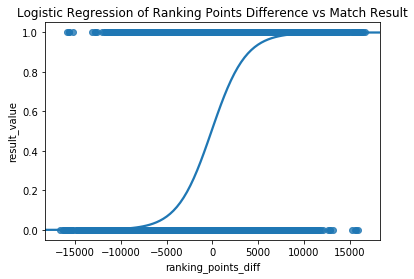

In [7]:
_ = sns.regplot(matches.ranking_points_diff, matches.result_value, logistic=True, n_boot=10)
_ = plt.title('Logistic Regression of Ranking Points Difference vs Match Result')

I will use the accuracy of the higher ranked metric as the score to beat. In the test matches, the higher ranked player only wins 60% of the time. How much better can I do with the features available to me?

In [8]:
test_matches_results = test_matches.result_value 
higher_ranked = test_matches.ranking_points_diff > 0
print(accuracy_score(test_matches_results, higher_ranked))

0.6045771144278607


Next, I'll  extract only the columns which pertain to the player. Columns such as "minutes" or "surface" affect both players and are not included. The target column is the "result_value" column, which represents a win as 1, and a loss as 0.

In [9]:
COLUMNS = ['height_diff', 'aces', 'double_faults',
       'service_points', 'first_serves', 'first_serves_won',
       'second_serves_won', 'service_games', 'break_points_saved',
       'break_points_faced', 'player_rank', 'ranking_points', 
       'first_serve_percentage', 'break_points_save_percentage',
       'service_points_won', 'service_points_won_percentage', 'points',
       'return_points', 'return_points_won', 'return_points_won_percentage',
       'first_serves_won_percentage', 'second_serves_won_percentage',
       'first_serve_return_points_won',
       'first_serve_return_points_won_percentage',
       'second_serve_return_points_won',
       'second_serve_return_points_won_percentage', 'break_points',
       'break_points_won', 'break_points_won_percentage', 'points_won',
       'ranking_points_diff', 'rank_diff', 'result_value']

Dropping all rows with NaN values results in an acceptable loss. In many cases, imputing the value would lead to an inaccurate representation of the match, and would propagate errors onto later matches.

In [10]:
recent_matches = recent_matches[COLUMNS].dropna()
recent_matches.shape

(38807, 33)

I will be using Scikit-Learn's GradientBoostingClassifier. Boosting is an ensemble algorithm that uses decision trees to classify data. Each tree aims to improve on older trees, "boosting" their performance as classifiers. It performs better than the Random Forest Classifier with default parameters, and does not overfit for the training data. Remarkably, the classifier has an accuracy of 94% out of the box. But should this be surprising? After all, we are providing the model with statistics that can only be calculated post-match. I have even removed the most obvious predictor, the percentage of points won.

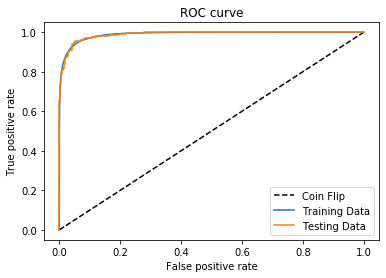

Train AUC: 0.9889721974637673
Test AUC: 0.9888927187581714
Test Accuracy: 0.9493314567206192


In [11]:
scaler = MinMaxScaler()
gb = GradientBoostingClassifier()
clf = make_pipeline(scaler, gb)

run_classifier(COLUMNS)

The percentage of points won on serve and return stand out as the most important features. In fact, when the classifier is run with only these two features, the score remains near 94%. Without them, however, the remaining features are robust enough to retain a 94% accuracy. Note that the ranking points difference carries very little weight. Betting on the favorite seems like a losing strategy if you have a time machine.

In [12]:
importances = gb.feature_importances_
indices = np.argsort(importances)[::-1]
[(COLUMNS[i], importances[i]) for i in indices[:11]]

[('service_points_won_percentage', 0.47904798857605074),
 ('return_points_won_percentage', 0.34980463679588497),
 ('break_points_won', 0.09289208135639802),
 ('break_points_save_percentage', 0.0444456214315933),
 ('break_points_won_percentage', 0.014039762509043218),
 ('return_points', 0.00976072993659952),
 ('break_points_faced', 0.003917657718559494),
 ('service_points_won', 0.001756579157969045),
 ('service_points', 0.0011375029877767188),
 ('points_won', 0.000692323296751005),
 ('ranking_points_diff', 0.0005037481560548445)]

## Step 2: Match Result Predictor

Can we train a classifier to predict the outcome of a match, using only data available prior to the match? This is a much more tricky question, as it drastically limits the features we can use. Let's start with only the columns available in the matches dataset.

The feature set has been reduced to only four features. 

In [13]:
COLUMNS = ['height_diff', 'ranking_points_diff', 'rank_diff', 'result_value']

The results are not promising. With a 62% accuracy, it's not doing much better than picking the favorite.

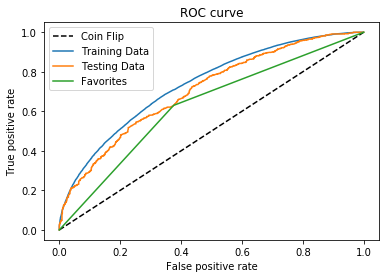

Train AUC: 0.7356607320090804
Test AUC: 0.7054750114661961
Favorite AUC: 0.6271721639627174
Test Accuracy: 0.6278054862842892


In [14]:
run_classifier(COLUMNS, vs=True)

As expected, the classifier relies on the ranking points difference the most. I'm back at square one and will need more features to beat those odds. Notably, height difference is not a significant factor.

In [15]:
importances = gb.feature_importances_
indices = np.argsort(importances)[::-1]
[(COLUMNS[i], importances[i]) for i in indices]

[('ranking_points_diff', 0.8756021357578633),
 ('rank_diff', 0.10738289269443191),
 ('height_diff', 0.017014971547704795)]

## Step 3: Career Data Acquisition

To give my predictive classifier more features, I'll need to generate career statistics for the players in the match.
I have done this using three pre-computed methods. RECENT_COLUMNS only uses match data from each player's last ten matches. These last ten matches are commonly seen on betting websites, and are intended to provide insight into whether a player is performing above or below their usual level.

PAST_YEAR_COLUMNS takes the average of all matches in the year prior to the match. This should give a longer-term view of a player's performance.

Finally, CAREER_COLUMNS averages all statistics prior to the match. Note that all of these feature sets are opponent-dependent. Unlike the post-match statistics, these features are not the reciprocal of the opponent's. To better represent them, the difference is taken to adjust the player's performance to the opponent's performance.

In [16]:
RECENT_COLUMNS = ['recent_aces', 'recent_double_faults',
       'recent_first_serve_percentage', 'recent_break_points_save_percentage', 'recent_service_points_won_percentage', 
       'recent_return_points_won_percentage',
       'recent_first_serves_won_percentage', 'recent_second_serves_won_percentage',
       'recent_first_serve_return_points_won_percentage',
       'recent_second_serve_return_points_won_percentage', 
       'recent_break_points_won_percentage',
       'recent_points_won_percentage']

PAST_YEAR_COLUMNS = ['past_year_aces', 'past_year_double_faults',
       'past_year_first_serve_percentage', 'past_year_break_points_save_percentage', 'past_year_service_points_won_percentage', 
       'past_year_return_points_won_percentage',
       'past_year_first_serves_won_percentage', 'past_year_second_serves_won_percentage',
       'past_year_first_serve_return_points_won_percentage',
       'past_year_second_serve_return_points_won_percentage', 
       'past_year_break_points_won_percentage',
       'past_year_points_won_percentage']

CAREER_COLUMNS = ['career_aces', 'career_double_faults',
       'career_first_serve_percentage', 'career_break_points_save_percentage', 'career_service_points_won_percentage', 
       'career_return_points_won_percentage',
       'career_first_serves_won_percentage', 'career_second_serves_won_percentage',
       'career_first_serve_return_points_won_percentage',
       'career_second_serve_return_points_won_percentage', 
       'career_break_points_won_percentage',
       'career_points_won_percentage']

To determine which metric performs best, I'll test all three feature sets separately. RECENT_COLUMNS outperforms the favorite-only metric, but not by much. This is surprising, as momentum and hot streaks have been long thought of as a significant factor in future performance.

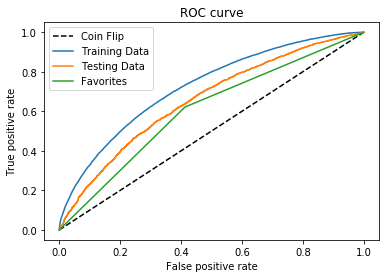

Train AUC: 0.7241794065414222
Test AUC: 0.6558495470091668
Favorite AUC: 0.6043311405600729
Test Accuracy: 0.6123953766440813


In [17]:
run_classifier(RECENT_COLUMNS + ['result_value'], vs=True)

The "recent points won percentage" feature overshadows the others. This feature is the best estimation for the degree by which a player has won or lost their recent matches. A high value suggests easy wins, and a low value suggests losses or struggles winning matches.

In [18]:
importances = gb.feature_importances_
indices = np.argsort(importances)[::-1]
[(RECENT_COLUMNS[i], importances[i]) for i in indices[:5]]

[('recent_points_won_percentage', 0.8400090537839332),
 ('recent_service_points_won_percentage', 0.04973392517005513),
 ('recent_break_points_save_percentage', 0.0256578457917956),
 ('recent_break_points_won_percentage', 0.018137443105938046),
 ('recent_double_faults', 0.016436096430582896)]

The PAST_YEAR feature set performs even worse, with an accuracy of 60%. Perhaps taking more matches into account reduces their potency as a predictor of future performance.

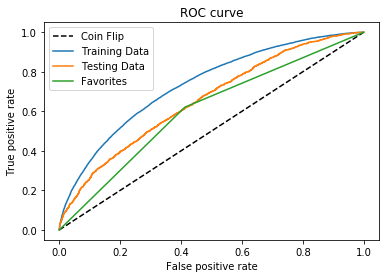

Train AUC: 0.7341510255579616
Test AUC: 0.6574714898947882
Favorite AUC: 0.6041901055417551
Test Accuracy: 0.6007165605095541


In [19]:
run_classifier(PAST_YEAR_COLUMNS + ['result_value'], vs=True)

"Points won percentage" rates ahead of the other features.

In [20]:
importances = gb.feature_importances_
indices = np.argsort(importances)[::-1]
[(PAST_YEAR_COLUMNS[i], importances[i]) for i in indices[:5]]

[('past_year_points_won_percentage', 0.8641609657318986),
 ('past_year_service_points_won_percentage', 0.025932177196338963),
 ('past_year_double_faults', 0.01829480645182425),
 ('past_year_first_serve_return_points_won_percentage', 0.01802140792390972),
 ('past_year_break_points_save_percentage', 0.015822845283741276)]

Using career statistics results in a performance boost. Without knowing the current rank difference, this classifier performs better than any of the previous models. Surprisingly, looking at recent results introduces more bias than looking at the entire career.

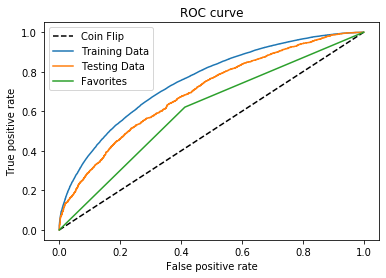

Train AUC: 0.7533051804125872
Test AUC: 0.6975377887798226
Favorite AUC: 0.6042577627719046
Test Accuracy: 0.6366354395056807


In [21]:
run_classifier(CAREER_COLUMNS + ['result_value'], vs=True)

The "career points won percentage" feature provides almost all of the predictive power in this model.

In [22]:
importances = gb.feature_importances_
indices = np.argsort(importances)[::-1]
[(CAREER_COLUMNS[i], importances[i]) for i in indices[:3]]

[('career_points_won_percentage', 0.9402267491836425),
 ('career_aces', 0.010525539142727471),
 ('career_service_points_won_percentage', 0.009429394248546928)]

It's time to tune the classifier. I'll use Scikit-Learn's GridSearchCV object to optimize the hyperparameters in my classifier, as well as a few pre-processing steps. My Pipeline will scale the features between 0 and 1 using the MinMaxScaler, then select the "k" best features using the chi-squared test. Finally, the GradientBoostingClassifier will fit the data, adjusting its learning rate, the number of estimators, and the maximum features to use.

My classifier works best when using all of the features. This is different from the other ensemble method, the Random Forest, which performs best when using a subset of the features. Gradient Boosting improves decision trees one at a time, so having all of the features available for improvement may "boost" performance. I am using the log loss as the scoring function to maximize. While classification accuracy is important, the presence of upsets prevents it from being a complete metric. Log loss penalizes confident mispredictions, which is more useful for calculating the odds of success prior to a match.

In [23]:
scale = MinMaxScaler()
chi = SelectKBest(chi2, k='all')
rf = RandomForestClassifier(n_estimators=200, max_features='sqrt')
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_features=None)
pipe = make_pipeline(scale, chi, gb)

# param_grid = {'gradientboostingclassifier__learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01],
#               'gradientboostingclassifier__n_estimators': [1, 5, 10, 25, 50, 100, 200],
#               'gradientboostingclassifier__max_features': [None, 'sqrt', 'log2']}
#               'selectkbest__k': [5, 10, 15, 20, 'all']

param_grid = {}

clf = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, iid=False, scoring='neg_log_loss')

For the feature columns, I'll be including everything from the previous models. I've also added a few extra features that I believe will be important in predicting success. These include:

"h2h" - The head-to-head between the two players. History between players may indicate a favorable matchup.

"winrate" - The career number of wins divided by the number of matches played.

"age_diff" - The difference in age between the players.

In [24]:
COLUMNS = ['ranking_points_diff', 'rank_diff',
       'recent_first_serve_percentage', 'recent_break_points_save_percentage', 'recent_service_points_won_percentage', 
       'recent_return_points_won_percentage',
       'recent_first_serves_won_percentage', 'recent_second_serves_won_percentage',
       'recent_first_serve_return_points_won_percentage',
       'recent_second_serve_return_points_won_percentage', 
       'recent_break_points_won_percentage',
       'recent_points_won_percentage',
       'past_year_first_serve_percentage', 'past_year_break_points_save_percentage', 
       'past_year_service_points_won_percentage', 
       'past_year_return_points_won_percentage',
       'past_year_first_serves_won_percentage', 'past_year_second_serves_won_percentage',
       'past_year_first_serve_return_points_won_percentage',
       'past_year_second_serve_return_points_won_percentage', 
       'past_year_break_points_won_percentage',
       'past_year_points_won_percentage',
       'career_first_serve_percentage', 'career_break_points_save_percentage', 'career_service_points_won_percentage', 
       'career_return_points_won_percentage',
       'career_first_serves_won_percentage', 'career_second_serves_won_percentage',
       'career_first_serve_return_points_won_percentage',
       'career_second_serve_return_points_won_percentage', 
       'career_break_points_won_percentage',
       'career_points_won_percentage', 'h2h', 'winrate', 'age_diff', 'result_value']

After hyperparameter tuning, cross-validation, and feature additions, the final model predicts the winner with a 65% accuracy. This may not seem very impressive, but upsets occur in roughly 40% of matches. This model accounts for 12% of the upsets and provides the correct victor.

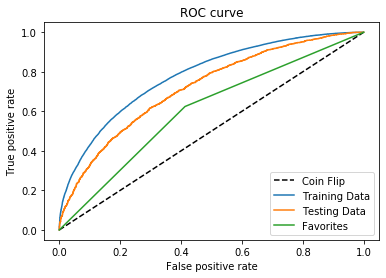

Train AUC: 0.781299491098714
Test AUC: 0.7194438738127185
Favorite AUC: 0.6055990759133703
Test Accuracy: 0.6549239391513211


In [25]:
run_classifier(COLUMNS, vs=True)

The best estimator relies mostly on the "career points won percentage" feature. After that, the "ranking points difference" and "recent points won percentage" features are the only significant factors. This may come as a disappointment for players looking to improve their performance. The important features are performance-independent. In other words, while the model favors winning more points, it doesn't provide insight into how to win those points. To achieve that, more thorough statistics are needed, such as those of total winners, unforced errors, forehand shots, backhand shots, and net approaches. If one had access to these statistics, it would be possible to determine the performance features required for success, at least for individual players. Some players may have already hired an analyst for such a task, but these statistics are not made available to the public.

In [26]:
importances = clf.best_estimator_.named_steps['gradientboostingclassifier'].feature_importances_
indices = np.argsort(importances)[::-1]
[(COLUMNS[i], importances[i]) for i in indices[:10]]

[('career_points_won_percentage', 0.6216504816981834),
 ('ranking_points_diff', 0.1639994909504664),
 ('recent_points_won_percentage', 0.11171449111553612),
 ('age_diff', 0.021610243217983605),
 ('rank_diff', 0.016339212230687523),
 ('winrate', 0.014118343964859401),
 ('recent_break_points_save_percentage', 0.0076123785071859585),
 ('recent_service_points_won_percentage', 0.006945771753845975),
 ('past_year_points_won_percentage', 0.005045655873303599),
 ('career_service_points_won_percentage', 0.004704715416967821)]

In closing, I would like to propose some methods to improve the model that I may explore in the future:

1. Factoring in the quality of opponents. Not all wins carry the same weight. A win versus a higher-ranked opponent may indicate either that the player played well or that the opponent played worse than their rank would suggest. In essence, an ELO system like the one used in chess.

2. Exponential decay of recent perfomance. Tracking the last ten matches may not mean much for a player who has been injured, or for matches played at the beginning of the year after a month-long offseason.

3. Including only performance-dependent features. By looking only at statistics like first-serve percentage, number of aces, etc., more insight could be gained from the feature extraction of the model.

Individual players have been reported to be working with analytics firms in recent years. However, the price of working with these firms is steep, and may not be feasible for lower-ranked players. Having a publicly-available resource for advanced analytics may require a community effort from tennis fans. I can only hope that one day tennis fans talk about silly acronyms like WHIP with a straight face just as they do in baseball.

### Bonus: A Shallow Dive into Deep Learning

The Deep Learning notebook details the process used to attain a small performance gain from the machine learning model. The Deep Learning Neural Network (with only one hidden layer, so not that deep) has an accuracy of 66.5%, predicting nearly 2/3rds of all matches correctly in the test set. This only increases my belief that to improve on my predictive model, better features are needed.

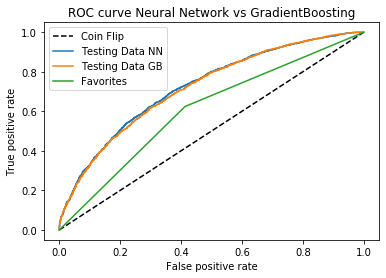

NN AUC: 0.7239001734987721
GB AUC: 0.7194438738127185
Favorite AUC: 0.6055990759133703

Test Accuracy NN: 0.6651321056845476
Test Accuracy GB: 0.6549239391513211
Favorite Accuracy: 0.6060848678943155


In [51]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from keras.models import load_model

best_model = load_model('best_model.h5')

train_matches = matches[(matches['tournament_date'] > '2009') & (matches['tournament_date'] < '2019')]
test_matches = matches[matches['tournament_date'] > '2019']

X_train = train_matches[COLUMNS].dropna().drop('result_value', axis=1)
y_train = train_matches[COLUMNS].dropna().result_value

X_test = test_matches[COLUMNS].dropna().drop('result_value', axis=1)
y_test = test_matches[COLUMNS].dropna().result_value

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_pred_nn = best_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_nn)

y_pred_gb = clf.predict_proba(X_test)[:, 1]
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_gb)

plt.plot([0, 1], [0, 1], 'k--', label='Coin Flip')
plt.plot(fpr, tpr, label='Testing Data NN')
plt.plot(fpr_gb, tpr_gb, label='Testing Data GB')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Neural Network vs GradientBoosting')

higher_ranked = test_matches.dropna(subset=COLUMNS).ranking_points_diff > 0
fpr_naive, tpr_naive, _ = roc_curve(y_test, higher_ranked.values)
plt.plot(fpr_naive, tpr_naive, label='Favorites')

plt.legend()
plt.show()

print(f'NN AUC: {roc_auc_score(y_test, y_pred_nn)}')
print(f'GB AUC: {roc_auc_score(y_test, y_pred_gb)}')
print(f'Favorite AUC: {roc_auc_score(y_test, higher_ranked)}\n')

print(f'Test Accuracy NN: {accuracy_score(y_test, best_model.predict_classes(X_test_scaled))}')
print(f'Test Accuracy GB: {accuracy_score(y_test, clf.predict(X_test))}')
print(f'Favorite Accuracy: {accuracy_score(y_test, higher_ranked)}')